# A/B test

Perform an A/B test on the dataset AB_Test_Results.csv. This dataset is from [Kaggle](https://www.kaggle.com/datasets/sergylog/ab-test-data).

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu

## Load data

In [2]:
df = pd.read_csv("Data/AB_Test_Results.csv")
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Create "BUY" column, 1 if "REVENUE" > 0, else 0.

In [3]:
df['BUY'] = 1*(df.REVENUE > 0)
df.head()

,USER_ID,VARIANT_NAME,REVENUE,BUY
0,737,variant,0.0,0
1,2423,control,0.0,0
2,9411,control,0.0,0
3,7311,control,0.0,0
4,6174,variant,0.0,0


## Sorting data

In [4]:
df_sorted = df.copy()
df_sorted.sort_values(['USER_ID', 'REVENUE'], inplace=True, ascending=[True, False])
df_sorted.head()

,USER_ID,VARIANT_NAME,REVENUE,BUY
2406,2,control,0.0,0
3479,2,control,0.0,0
7076,2,control,0.0,0
4145,3,variant,0.0,0
5377,3,control,0.0,0


We sorted the data and removed duplicate entries to maximize revenue retention. Next, we added the columns "RANK_REVENUE" and "RANK_CONVERSION", representing the average ranks of "REVENUE" and "BUY", respectively. This step prepares the dataset for the Mann-Whitney U test.

In [5]:
df_sorted = df_sorted.drop_duplicates(subset=['USER_ID']).copy()

In [6]:
df_sorted.loc[:, 'RANK_REVENUE'] = df_sorted['REVENUE'].rank(method='average')
df_sorted.loc[:, 'RANK_CONVERSION'] = df_sorted['BUY'].rank(method='average')

df_sorted

,USER_ID,VARIANT_NAME,REVENUE,BUY,RANK_REVENUE,RANK_CONVERSION
2406,2,control,0.00,0,3087.5,3087.5
4145,3,variant,0.00,0,3087.5,3087.5
9077,4,variant,0.00,0,3087.5,3087.5
9155,5,variant,0.00,0,3087.5,3087.5
7720,6,variant,0.00,0,3087.5,3087.5
...,...,...,...,...,...,...
9290,9993,control,0.00,0,3087.5,3087.5
2749,9995,variant,0.00,0,3087.5,3087.5
5915,9996,variant,6.46,1,6295.0,6249.5
1064,9998,control,0.00,0,3087.5,3087.5


In [7]:
df_control = df_sorted[df_sorted.VARIANT_NAME == 'control'].copy()
df_variant = df_sorted[df_sorted.VARIANT_NAME == 'variant'].copy()

## Any intersection between control and variant groups?

Having the same users in both the control and variant groups would lead to inaccurate results, as each user would be counted twice, skewing the data. Therefore, before conducting any analysis, we need to remove duplicate users.

In [8]:
df_overlap = pd.merge(df_control, df_variant, on="USER_ID").copy()
df_overlap

,USER_ID,VARIANT_NAME_x,REVENUE_x,BUY_x,RANK_REVENUE_x,RANK_CONVERSION_x,VARIANT_NAME_y,REVENUE_y,BUY_y,RANK_REVENUE_y,RANK_CONVERSION_y


There is no overlap between the control and variant groups, so we can now proceed with the A/B test."

## Metric

There are two ways to conduct an A/B test, depending on the metric used:
- Conversions refer to any action taken online that aligns with a business’s goals, such as filling out a form, making a purchase, or completing a survey.
- Revenue is a continuous metric that directly impacts the business's bottom line.

First, we consider conversion rate, which represents the number of conversions within a given timeframe and is typically expressed as a percentage. For example, if 100 visitors access a website and 10 make a purchase, the conversion rate is 10%. This metric helps businesses assess how effectively their website converts visitors into customers.

Secondly, we also conducted an A/B test on revenue, as a high conversion rate does not necessarily imply high revenue. For example, Amour Beauty Box may have more people signing up for the monthly box, resulting in a high conversion rate but lower revenue. Conversely, if fewer people sign up but opt for annual payments, it would yield a lower conversion rate but higher revenue.


In [9]:
conversion = {'Control': (sum(df_control.BUY == 0),
                         sum(df_control.BUY == 1)),
            'Variant': (sum(df_variant.BUY == 0),
                         sum(df_variant.BUY == 1))}
conversion

{'Control': (3048, 80), 'Variant': (3126, 70)}

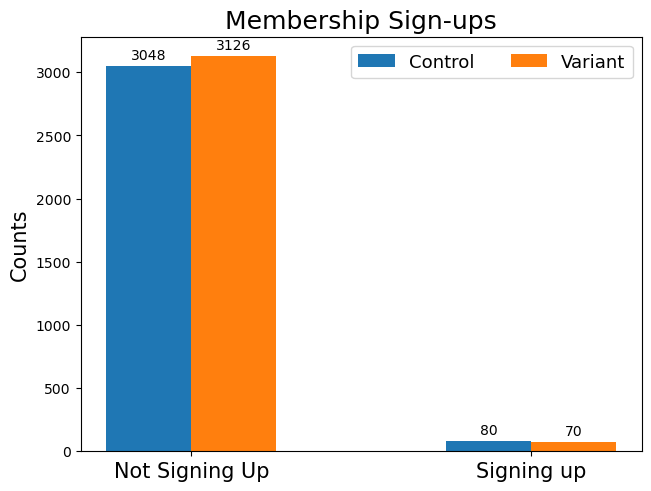

In [10]:
x = np.arange(2)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in conversion.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts', fontsize=15)
ax.set_title('Membership Sign-ups', fontsize=18)
ax.set_xticks(x + width/2, ['Not Signing Up', 'Signing up'], fontsize=15)
ax.legend(loc='upper right', ncols=3, fontsize=13)
#plt.tight_layout()
plt.savefig("Figure/membership_signups.jpg")

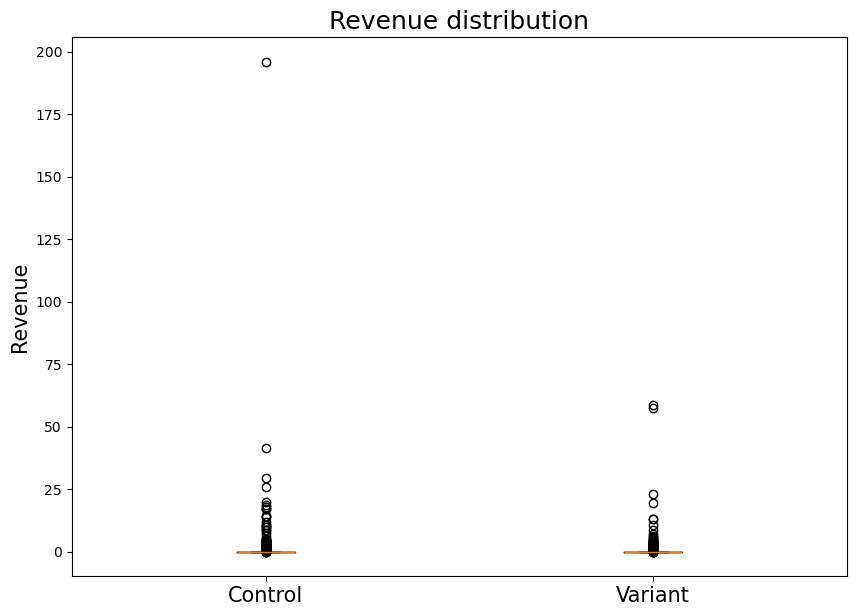

In [11]:
plt.figure(figsize =(10, 7))

plt.boxplot([df_control.REVENUE, df_variant.REVENUE])
plt.xticks([1, 2], ['Control', 'Variant'], fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.title('Revenue distribution', fontsize=18)
plt.savefig("Figure/revenue_distribution.jpg")

## Normality test

Since our sample size is large, we choose not to use the T-test. There are several options for conducting an A/B test, depending on whether the data is normally distributed. If the conversion rate or revenue follows a Gaussian distribution, we will perform a Z-test. Otherwise, we recommend using the Mann-Whitney U test, a non-parametric method that does not require the assumption of normality. Therefore, our first step is to test for normality.

In [12]:
def normal_test(data):
    stat, p = normaltest(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [13]:
normal_test(df_control.REVENUE)

Statistics=9552.712, p=0.000
Sample does not look Gaussian (reject H0)


In [14]:
normal_test(df_variant.REVENUE)

Statistics=8273.628, p=0.000
Sample does not look Gaussian (reject H0)


In [15]:
normal_test(df_control.BUY)

Statistics=3490.598, p=0.000
Sample does not look Gaussian (reject H0)


In [16]:
normal_test(df_variant.BUY)

Statistics=3781.952, p=0.000
Sample does not look Gaussian (reject H0)


We found that neither revenue nor conversion rate follows a Gaussian distribution. Therefore, we chose the Mann-Whitney U test for our analysis.

## Mann Whitney U Test/ Wilcoxon rank sum test

The Mann-Whitney U test is equivalent to an independent t-test. It does not assume normality and works well with small sample sizes.

Steps for Mann Whitney U Test:

1. Collect two independent samples.
2. Rank the data from smallest to largest across both groups. If two observations have the same value, assign them the average rank.
3. Sum the ranks for each sample (denoted as $R_1$ and $R_2$)
4. Calculate the U-statistics:

$$ U_1 = n_1 n_2 + \frac{n_1(n_1 + 1)}{2} - R_1 $$

$$ U_2 = n_1 n_2 + \frac{n_2(n_2 + 1)}{2} - R_2 $$

where 
- $n_1$ and $n_2$ are sample sizes for the two groups
- $R_1$ and $R_2$ are the rank sums of each group

The final U-statistics is the smallest value of $U_1$ and $U_2$.

5. Compare U to the critical value from the Mann-Whitney U Table at the chosen significance level (e.g. 0.05)
6. Decision rules:
- If $U \le U_0$, rejects the null hypothesis.
- Else, do not reject the null hypothesis.

In [17]:
R1_conversion = sum(df_control.RANK_CONVERSION)
R2_conversion = sum(df_variant.RANK_CONVERSION)

In [18]:
n1 = len(df_control)
n2 = len(df_variant)

In [19]:
U1_conversion = n1*n2 + (n1*(n1 + 1)/2) - R1_conversion
U2_conversion = n1*n2 + (n2*(n2 + 1)/2) - R2_conversion
U_conversion = min(U1_conversion, U2_conversion)
U_conversion

4980184.0

In [20]:
R1_revenue = sum(df_control.RANK_REVENUE)
R2_revenue = sum(df_variant.RANK_REVENUE)

In [21]:
U1_revenue = n1*n2 + (n1*(n1 + 1)/2) - R1_revenue
U2_revenue = n1*n2 + (n2*(n2 + 1)/2) - R2_revenue
U_revenue = min(U1_revenue, U2_revenue)
U_revenue

4979759.0

## Compute p value from Mann  U Test

For small sample sizes, the exact distribution of U can be calculated, and the p-value can be determined directly from the CDF. However, for larger sample sizes, the distribution of U can be approximated by a normal distribution, and the p-value can be calculated using the standard normal CDF.

Expected value of U:

$$\mu_U = \frac{n_1 \cdot n_2}{2}$$

Standard error of U:

$$\sigma_U = \sqrt{\frac{n_1 \cdot n_2 \cdot (n_1 + n_2 + 1)}{12}}$$

z-value is:

$$z = \frac{U - \mu_U}{\sigma_U}$$

The p-value can be obtained this way.

In [22]:
def p_val_computation(U, n1, n2, method:str):
    mu_u = n1*n2/2
    s_u = np.sqrt(n1*n2*(n1 + n2 + 1)/12)
    z = (U - mu_u)/s_u
    if method == 'right':
        p = 1 - stats.norm.cdf(z)
    elif method == 'left':
        p = stats.norm.cdf(z)
    elif method == 'two-tailed':
        p = 2 * stats.norm.cdf(-abs(z))

    return p

In [23]:
p_conversion = p_val_computation(U_conversion, n1, n2, 'right')
p_conversion

0.5998379317241425

Since $p_{\text{conversion}} > 0.05$, we fail to reject the null hypothesis, indicating that the implemented change does not lead to a statistically significant increase in the conversion rate. In other words, the modification did not result in more sign-ups, suggesting that the adjustment had little to no impact on user behavior. This outcome highlights the importance of further analysis to understand potential influencing factors, such as user preferences, market conditions, or additional website optimizations that could drive engagement and improve conversion rates.

In [24]:
p_revenue = p_val_computation(U_revenue, n1, n2, 'right')
p_revenue

0.6020984455506847

Since $p_{\text{revenue} > 0.05}$, we fail to reject the second null hypothesis. This indicates that the implemented change does not lead to a statistically significant increase in revenue. In other words, the modification has not contributed to higher earnings, suggesting that the adjustment had little to no measurable impact on user spending or purchasing behavior. This outcome underscores the need for further analysis to explore potential factors influencing revenue, such as pricing strategies, customer retention efforts, or external market conditions that could drive financial growth.